<a href="https://colab.research.google.com/github/ANJU-TECKZ/Abnormal_Activity_Detect_Surveillance_Videos/blob/main/Copy_of_detect_VID_DWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ABNORMAL ACTIVITY DETECTION VIA DEEP LEARNING

In [ ]:
# import the necessary packages
import os
# initialize the path to the fire and non-fire dataset directories
FIRE_PATH = "/content/drive/My Drive/Colab Notebooks/VidData/DATA/FIRE"
ACC_PATH = "/content/drive/My Drive/Colab Notebooks/VidData/DATA/ACCIDENT"
ROB_PATH = "/content/drive/My Drive/Colab Notebooks/VidData/DATA/ROBBERY"
NORMAL_PATH = "/content/drive/My Drive/Colab Notebooks/VidData/DATA/NORMAL"
 
# initialize the class labels in the dataset
CLASSES = ["Normal", "Fire", "Accident", "Robbery"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25
 
# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 100

In [ ]:
# set the path to the serialized model after training
#MODEL_PATH = os.path.sep.join(["output", "activity_detection_DWS.model"])

In [ ]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
#matplotlib.use("Agg")
 
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and resize it to be a fixed 128x128 pixels,
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))
        # add the image to the data lists
        data.append(image)
        # return the data list as a NumPy array
    return np.array(data, dtype="float32")

## DATA LOADING

In [ ]:
# load the images
print("[INFO] loading normal data...")
normalData = load_dataset(NORMAL_PATH)
print("[INFO] loading fire data...")
fireData = load_dataset(FIRE_PATH)
print("[INFO] loading accident data...")
accidentData = load_dataset(ACC_PATH)
print("[INFO] loading robbery data...")
robberyData = load_dataset(ROB_PATH)

[INFO] loading normal data...
[INFO] loading fire data...
[INFO] loading accident data...
[INFO] loading robbery data...


In [ ]:
print(CLASSES)

['Normal', 'Fire', 'Accident', 'Robbery']


In [ ]:
print("Loaded Data")
print("NormalData.shape:",normalData.shape)
print("FireData.shape:",fireData.shape)
print("AccidentData.shape:",accidentData.shape)
print("RobberyData.shape:",robberyData.shape)

Loaded Data
NormalData.shape: (3123, 128, 128, 3)
FireData.shape: (1563, 128, 128, 3)
AccidentData.shape: (2654, 128, 128, 3)
RobberyData.shape: (2276, 128, 128, 3)


Using TensorFlow backend.


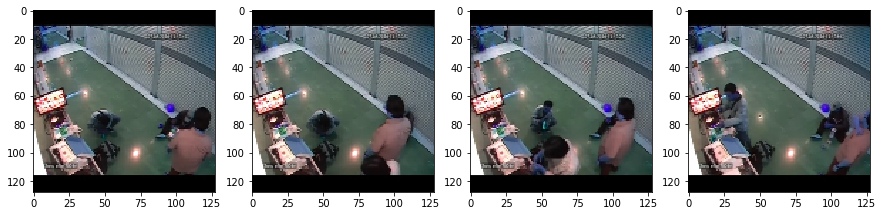

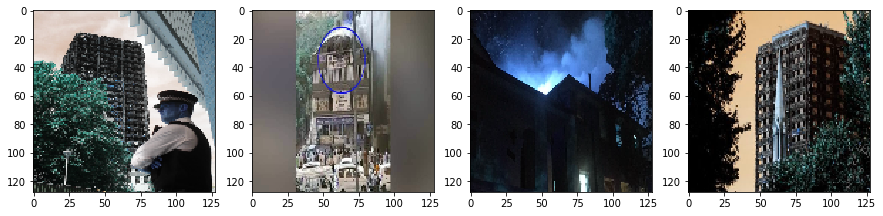

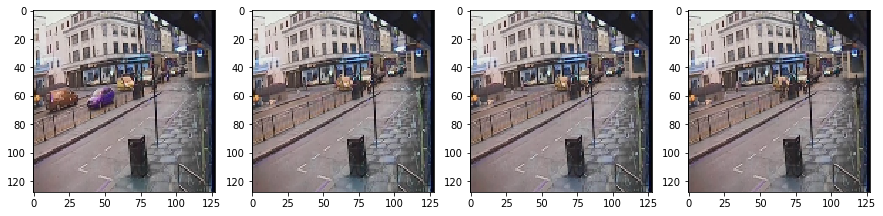

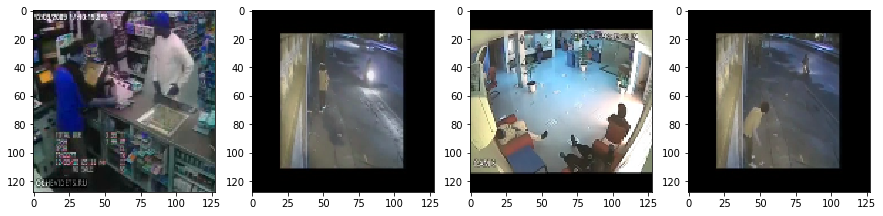

In [ ]:
from keras.preprocessing.image import img_to_array, array_to_img

fig, ax1 = plt.subplots(nrows = 1, ncols=4, figsize=(15,5))
for c, ax1 in zip(range(4), ax1): 
    ax1.grid(False)
    ax1.imshow(array_to_img(normalData[c]))
    
fig, ax2 = plt.subplots(nrows = 1, ncols=4, figsize=(15,5))
for c, ax2 in zip(range(4), ax2): 
    ax2.grid(False)
    ax2.imshow(array_to_img(fireData[c]))
    
fig, ax3 = plt.subplots(nrows = 1, ncols=4, figsize=(15,5))
for c, ax3 in zip(range(4), ax3): 
    ax3.grid(False)
    ax3.imshow(array_to_img(accidentData[c]))
    
fig, ax4 = plt.subplots(nrows = 1, ncols=4, figsize=(15,5))
for c, ax4 in zip(range(4), ax4): 
    ax4.grid(False)
    ax4.imshow(array_to_img(robberyData[c]))
    
plt.show()

## DATA DISTRIBUTION PLOT

<Figure size 432x288 with 0 Axes>

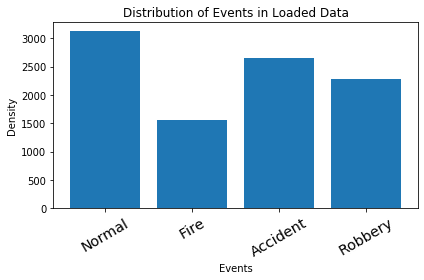

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
label = CLASSES
file_count = [normalData.shape[0],fireData.shape[0],accidentData.shape[0],robberyData.shape[0]]
index=np.arange(len(label))
plt.bar(index,file_count)
plt.xlabel('Events')
plt.ylabel('Density')
plt.xticks(index,label,rotation=30,fontsize = 'x-large')
plt.title('Distribution of Events in Loaded Data')
plt.tight_layout()
plt.savefig('train_data_distribution.pdf', format='pdf', dpi=1000)
#plt.style.use("ggplot")
plt.figure()

## DATA ANALYSIS

In [ ]:
# construct the class labels for the data
normalLabels = np.zeros((normalData.shape[0],))
fireLabels = np.ones((fireData.shape[0],))
accidentLabels = np.full(accidentData.shape[0],2)
robberyLabels = np.full(robberyData.shape[0],3)
print("[INFO] Label created for all data...")
labels = np.hstack([normalLabels, fireLabels, accidentLabels, robberyLabels])
labels = labels.astype(int)
# stack the fire data with the non-fire data
print("[INFO] stacking data...")
data = np.vstack([normalData, fireData, accidentData, robberyData])
data /= 255    #scale the data to the range [0, 1]

[INFO] Label created for all data...
[INFO] stacking data...


In [ ]:
data.shape

(9616, 128, 128, 3)

In [ ]:
labels.shape

(9616,)

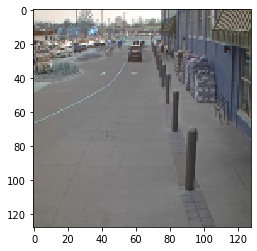

In [ ]:
pic = data[1101]
plt.grid(False)
plt.imshow(pic)

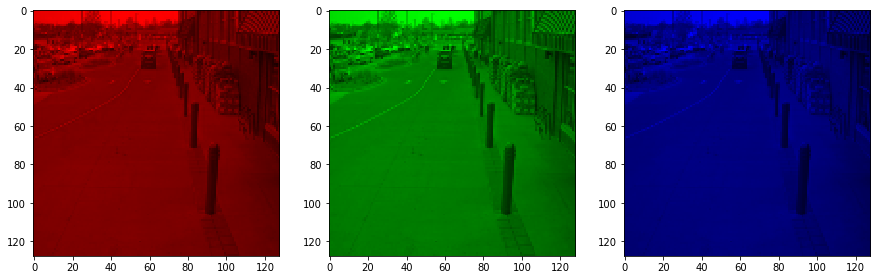

In [ ]:
# display each channel
import numpy as np
from keras.preprocessing.image import image
pic = data[1101]
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))
for c, ax in zip(range(3), ax):
    # create zero matrix
    split_img = np.zeros(pic.shape, dtype="float32") # 'dtype' by default: 'numpy.float64'
    # assing each channel 
    split_img[ :, :, c] = pic[ :, :, c]
    ax.grid(False)
    # display each channel
    ax.imshow(split_img)
plt.show()

In [ ]:
# perform one-hot encoding on the labels and account for skew in the labeled data
#labels = to_categorical(labels, num_classes=4)
classTotals = labels.sum(axis = 0)
classWeight = classTotals.max() / classTotals

## DATA TRAIN - TEST SPLIT

In [ ]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = TEST_SPLIT, random_state = 42)

In [ ]:
trainX.shape

(7212, 128, 128, 3)

In [ ]:
trainY.shape

(7212,)

In [ ]:
testX.shape

(2404, 128, 128, 3)

In [ ]:
testY.shape

(2404,)

## DATA AUGUMEMTATION

In [ ]:
# initialize the training data augmentation object
aug = ImageDataGenerator(rotation_range = 30,
                         zoom_range = 0.15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range = 0.15,
                         horizontal_flip = True,
                         fill_mode = "nearest")

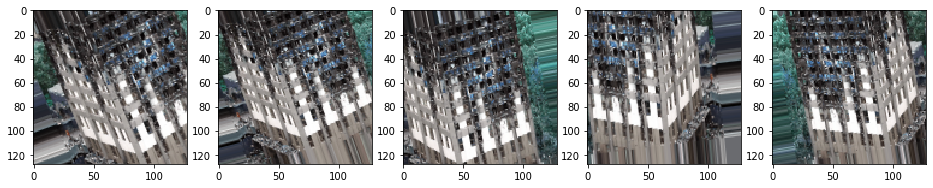

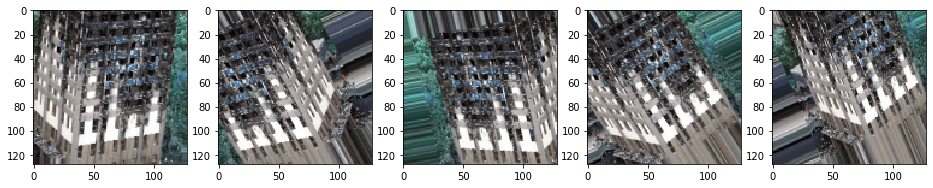

In [ ]:
#Visualizing Data Augumentation
img_id = 113
cat_generator = aug.flow(trainX[img_id:img_id+1], trainY[img_id:img_id+1], batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax= plt.subplots(1,5, figsize=(16, 8))
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]
img_id = 113
cat_generator = aug.flow(trainX[img_id:img_id+1], trainY[img_id:img_id+1], batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax1= plt.subplots(1,5, figsize=(16, 8))
l = [ax1[i].imshow(cat[i][0][0]) for i in range(0,5)]

## MODEL BUILDING 

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
 
class FireDetectionNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1
        
        # CONV => RELU => POOL
        model.add(SeparableConv2D(16, (7, 7), padding="same",input_shape=inputShape, activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # CONV => RELU => POOL
        model.add(SeparableConv2D(32, (3, 3), padding="same",activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # (CONV => RELU) * 2 => POOL
        model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
        #model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        # first set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # second set of FC => RELU layers
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        # return the constructed network architecture
        return model

In [ ]:
model = FireDetectionNet.build(width = 128, height= 128, depth = 3, classes = 4)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 128, 128, 16)      211       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 64, 64, 32)        688       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________

In [ ]:
# initialize the optimizer and model
opt = SGD(lr = INIT_LR, momentum = 0.9, decay = INIT_LR / NUM_EPOCHS)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics =["accuracy"])
print("[INFO] compiling model...")

#Utilize callback to store the weights of the best model
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_DWS.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=1)

[INFO] compiling model...


Using TensorFlow backend.


## MODEL TRAINING

In [ ]:
# train the network
print("[INFO] training network...")
import datetime
tstart= datetime.datetime.now()
H = model.fit_generator(aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
                        validation_data = (testX, testY),
                        steps_per_epoch = trainX.shape[0] // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        class_weight = classWeight,
                        callbacks = [checkpointer],
                        verbose = 1)
tend= datetime.datetime.now()
timeTaken = tend-tstart
print("time for training(ms):",int(timeTaken.total_seconds()*1000))


[INFO] training network...
Epoch 1/100
2404/112 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 419us/sample - loss: 1.3798 - acc: 0.3299

Epoch 00001: val_acc improved from -inf to 0.32987, saving model to /content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_DWS.hdf5
112/112 [==============================] - 38s 343ms/step - loss: 1.3804 - acc: 0.4505 - val_loss: 1.4067 - val

In [ ]:
Ttime=timeTaken
print("Time for 100 epochs:",
      Ttime.seconds//3600, "hours",
      (Ttime.seconds//60)%60,"minutes")

time for 100 epochs: 0 hours 51 minutes


### Accuracy and Loss during Training and Validation

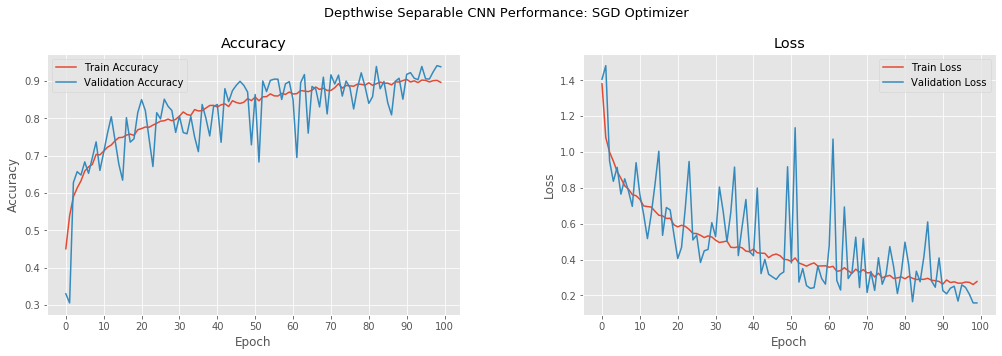

In [ ]:
#Plotting Accuracy and Loss during training and validation
plt.style.use("ggplot")
N = np.arange(0, NUM_EPOCHS)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
t = f.suptitle('Depthwise Separable CNN Performance: SGD Optimizer', fontsize=13)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(N, H.history['acc'], label = 'Train Accuracy')
ax1.plot(N, H.history['val_acc'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = "best")

ax2.plot(N,H.history['loss'], label = 'Train Loss')
ax2.plot(N, H.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

In [ ]:
#Load our classifier with the weights of the best model
model.load_weights('/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_DWS.hdf5')

#Saving the complete model
model.save('/content/drive/My Drive/Colab Notebooks/VidData/DATA/activity_detection_DWS.h5')

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
#model.save(MODEL_PATH)

## TESTING AND EVALUATION

In [ ]:
loss,acc = model.evaluate(testX,testY,verbose = 1)
print('Accuracy: %f'%(acc*100))

2404/2404 [==============================] - 1s 363us/sample - loss: 0.1591 - acc: 0.9413
Accuracy: 94.134778


In [ ]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size = BATCH_SIZE)

print(classification_report(testY, 
                            predictions.argmax(axis = 1), 
                            target_names = CLASSES))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       795
        Fire       0.88      0.94      0.91       383
    Accident       0.95      0.88      0.91       652
     Robbery       0.93      0.97      0.95       574

    accuracy                           0.94      2404
   macro avg       0.93      0.94      0.94      2404
weighted avg       0.94      0.94      0.94      2404



<Figure size 432x288 with 0 Axes>

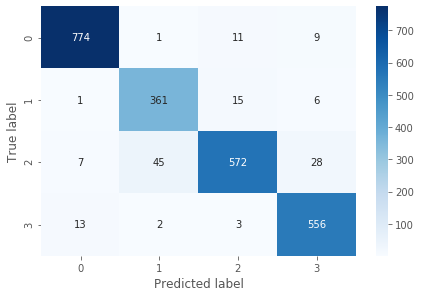

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
con_mat = confusion_matrix(testY, predictions.argmax(axis = 1))
#print(con_mat)
figure = plt.figure()
sns.heatmap(con_mat, annot=True, cmap=plt.cm.Blues,fmt="d")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure()

## PREDICTION 

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
from imutils import paths
import numpy as np
import imutils
import random
import cv2
import os
 
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('/content/drive/My Drive/Colab Notebooks/VidData/DATA/activity_detection_DWS.h5')

[INFO] loading model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Prediction from Video Input

In [ ]:
def predict(path):
    #Load video 
    from bokeh.plotting import figure
    from bokeh.io import output_notebook, show, push_notebook
    import cv2
    import time
    output_notebook()

    cap = cv2.VideoCapture(path)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    frame = cv2.flip(frame, 0) # because Bokeh flips vertically
    width = frame.shape[1]
    height = frame.shape[0]
    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=700, height=400)
    myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
    label = []
    show(p, notebook_handle = True)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            img = frame
            img = cv2.resize(img,(128, 128),interpolation=cv2.INTER_AREA)
            img = img.astype("float32") / 255.0
            preds = model.predict(np.expand_dims(img, axis=0))[0]
            j = np.argmax(preds)
            label = CLASSES[j]
            #print("Predicted Class : ",label)
            cv2.putText(frame, label, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 5)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            frame = cv2.flip(frame, 0)
            myImage.data_source.data['image'] = [frame]
            push_notebook()
            if cv2.waitKey(1) & 0xFF == ord('q'): # press q to quit
                break
        else:
            break
        #time.sleep(0.2)
    cap.release()
    print('Detected Activity:', label)

In [ ]:
predict(input('path:'))#input/video/Normal_Videos_006_x264.mp4

path:/content/drive/My Drive/Colab Notebooks/normal/Normal_Videos_050_x264.mp4


# Training with Adam Optimizer

In [ ]:
model_1 = FireDetectionNet.build(width = 128, height= 128, depth = 3, classes = 4)

In [ ]:
# initialize the optimizer and model  RMSprop
from tensorflow.keras.optimizers import Adam
opt_1 = Adam()
model_1.compile(loss = "sparse_categorical_crossentropy", optimizer = opt_1, metrics =["accuracy"])
print("[INFO] compiling model...")

#Utilize callback to store the weights of the best model
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_DWS_Adam.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=1)

[INFO] compiling model...


In [ ]:
# train the network
print("[INFO] training network...")
import datetime
tstart= datetime.datetime.now()
H1 = model_1.fit_generator(aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
                        validation_data = (testX, testY),
                        steps_per_epoch = trainX.shape[0] // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        class_weight = classWeight,
                        callbacks = [checkpointer],
                        verbose = 1)
tend= datetime.datetime.now()
timeTaken = tend-tstart
print("time for training(ms):",int(timeTaken.total_seconds()*1000))

[INFO] training network...
Epoch 1/100
2404/112 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 404us/sample - loss: 2.9495 - acc: 0.2712

Epoch 00001: val_acc improved from -inf to 0.27121, saving model to /content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_DWS_Adam.hdf5
112/112 [==============================] - 34s 301ms/step - loss: 1.5452 - acc: 0.4454 - val_loss: 2.8443 

In [ ]:
Ttime=timeTaken
print("Time for 100 epochs:",
      Ttime.seconds//3600, "hours",
      (Ttime.seconds//60)%60,"minutes")

Time for 100 epochs: 0 hours 50 minutes


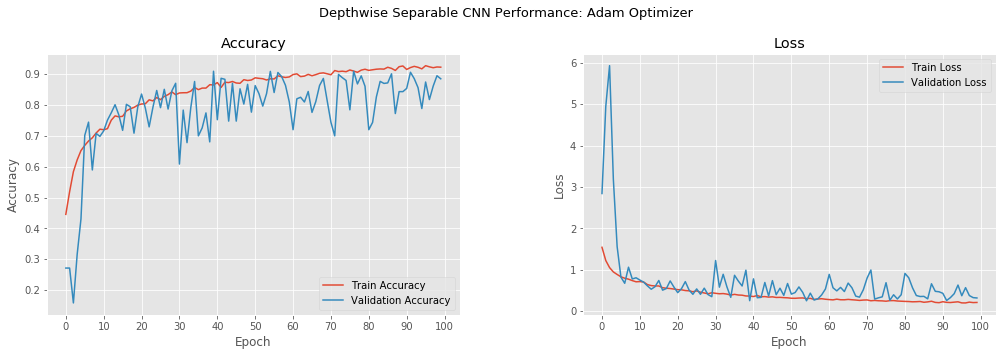

In [ ]:
#Plotting Accuracy and Loss during training and validation
plt.style.use("ggplot")
N = np.arange(0, NUM_EPOCHS)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
t = f.suptitle('Depthwise Separable CNN Performance: Adam Optimizer', fontsize=13)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(N, H1.history['acc'], label = 'Train Accuracy')
ax1.plot(N, H1.history['val_acc'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = "best")

ax2.plot(N,H1.history['loss'], label = 'Train Loss')
ax2.plot(N, H1.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

In [ ]:
#Load our classifier with the weights of the best model
model_1.load_weights('/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_DWS_Adam.hdf5')

#Saving the complete model
model_1.save('/content/drive/My Drive/Colab Notebooks/VidData/DATA/activity_detection_DWS_Adam.h5')

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
#model_1.save(MODEL_PATH)

In [ ]:
loss,acc = model_1.evaluate(testX,testY,verbose = 1)
print('Accuracy: %f'%(acc*100))

2404/2404 [==============================] - 1s 354us/sample - loss: 0.2566 - acc: 0.9097
Accuracy: 90.973377


In [ ]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model_1.predict(testX, batch_size = BATCH_SIZE)

print(classification_report(testY, 
                            predictions.argmax(axis = 1), 
                            target_names = CLASSES))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       0.96      0.93      0.95       795
        Fire       0.85      0.97      0.91       383
    Accident       0.94      0.82      0.87       652
     Robbery       0.87      0.94      0.90       574

    accuracy                           0.91      2404
   macro avg       0.90      0.92      0.91      2404
weighted avg       0.91      0.91      0.91      2404



<Figure size 432x288 with 0 Axes>

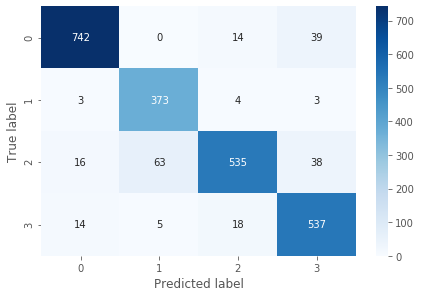

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
con_mat = confusion_matrix(testY, predictions.argmax(axis = 1))
#print(con_mat)
figure = plt.figure()
sns.heatmap(con_mat, annot=True, cmap=plt.cm.Blues,fmt="d")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure()

# Training with RMSProp Optimizer

In [ ]:
model_2 = FireDetectionNet.build(width = 128, height= 128, depth = 3, classes = 4)
# initialize the optimizer and model  RMSprop
from tensorflow.keras.optimizers import RMSprop
opt_2 = RMSprop()
model_2.compile(loss = "sparse_categorical_crossentropy", optimizer = opt_2, metrics =["accuracy"])
print("[INFO] compiling model...")

#Utilize callback to store the weights of the best model
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_DWS_RMS.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=1)

[INFO] compiling model...


In [ ]:
# train the network
print("[INFO] training network...")
import datetime
tstart= datetime.datetime.now()
H2 = model_2.fit_generator(aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
                        validation_data = (testX, testY),
                        steps_per_epoch = trainX.shape[0] // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        class_weight = classWeight,
                        callbacks = [checkpointer],
                        verbose = 1)
tend= datetime.datetime.now()
timeTaken = tend-tstart
print("time for training(ms):",int(timeTaken.total_seconds()*1000))

[INFO] training network...
Epoch 1/100
2404/112 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 1s 448us/sample - loss: 2.5057 - acc: 0.1593

Epoch 00001: val_acc improved from -inf to 0.15932, saving model to /content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_DWS_RMS.hdf5
112/112 [==============================] - 34s 303ms/step - loss: 1.5385 - acc: 0.4510 - val_loss: 2.4514 - val

In [ ]:
Ttime=timeTaken
print("Time for 100 epochs:",
      Ttime.seconds//3600, "hours",
      (Ttime.seconds//60)%60,"minutes")

Time for 100 epochs: 0 hours 50 minutes


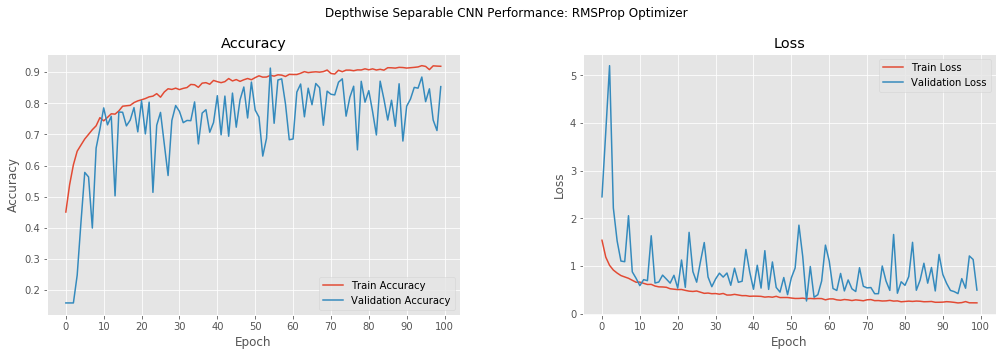

In [ ]:
#Plotting Accuracy and Loss during training and validation
plt.style.use("ggplot")
N = np.arange(0, NUM_EPOCHS)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
t = f.suptitle('Depthwise Separable CNN Performance: RMSProp Optimizer', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(N, H2.history['acc'], label = 'Train Accuracy')
ax1.plot(N, H2.history['val_acc'], label = 'Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = "best")

ax2.plot(N,H2.history['loss'], label = 'Train Loss')
ax2.plot(N, H2.history['val_loss'], label = 'Validation Loss')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

In [ ]:
#Load our classifier with the weights of the best model
model_2.load_weights('/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_DWS_RMS.hdf5')

#Saving the complete model
model_2.save('/content/drive/My Drive/Colab Notebooks/VidData/DATA/activity_detection_DWS_RMS.h5')

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
#model.save(MODEL_PATH)

In [ ]:
loss,acc = model_2.evaluate(testX,testY,verbose = 1)
print('Accuracy: %f'%(acc*100))

2404/2404 [==============================] - 1s 357us/sample - loss: 0.2624 - acc: 0.9131
Accuracy: 91.306156


In [ ]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model_2.predict(testX, batch_size = BATCH_SIZE)

print(classification_report(testY, 
                            predictions.argmax(axis = 1), 
                            target_names = CLASSES))

[INFO] evaluating network...
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       795
        Fire       0.84      0.95      0.89       383
    Accident       0.91      0.85      0.88       652
     Robbery       0.92      0.91      0.92       574

    accuracy                           0.91      2404
   macro avg       0.91      0.91      0.91      2404
weighted avg       0.91      0.91      0.91      2404



<Figure size 432x288 with 0 Axes>

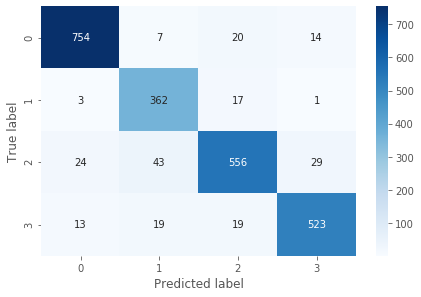

<Figure size 432x288 with 0 Axes>

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
con_mat = confusion_matrix(testY, predictions.argmax(axis = 1))
#print(con_mat)
figure = plt.figure()
sns.heatmap(con_mat, annot=True, cmap=plt.cm.Blues,fmt="d")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure()

# Comparison of Performance of Different Optimizers

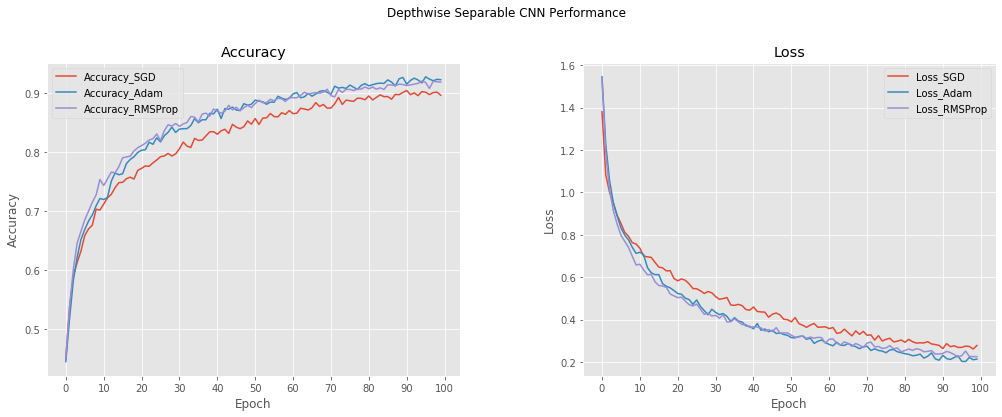

In [ ]:
#Plotting Accuracy and Loss during training 
plt.style.use("ggplot")
N = np.arange(0, NUM_EPOCHS)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))
t = f.suptitle('Depthwise Separable CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(N, H.history['acc'], label = 'Accuracy_SGD')
ax1.plot(N, H1.history['acc'], label = 'Accuracy_Adam')
ax1.plot(N, H2.history['acc'], label = 'Accuracy_RMSProp')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = "best")

ax2.plot(N,H.history['loss'], label = 'Loss_SGD')
ax2.plot(N,H1.history['loss'], label = 'Loss_Adam')
ax2.plot(N, H2.history['loss'], label = 'Loss_RMSProp')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

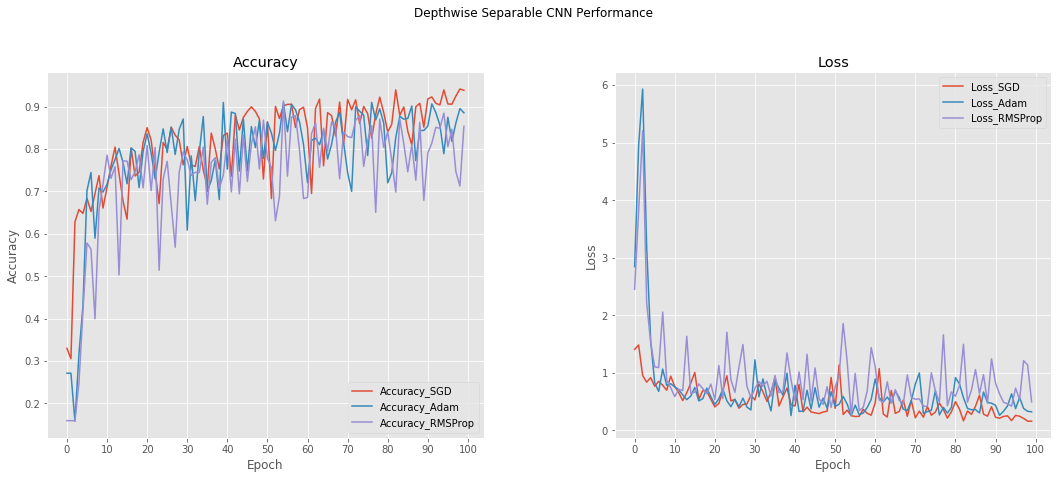

In [ ]:
#Plotting Accuracy and Loss during validation
plt.style.use("ggplot")
N = np.arange(0, NUM_EPOCHS)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
t = f.suptitle('Depthwise Separable CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(N, H.history['val_acc'], label = 'Accuracy_SGD')
ax1.plot(N, H1.history['val_acc'], label = 'Accuracy_Adam')
ax1.plot(N, H2.history['val_acc'], label = 'Accuracy_RMSProp')
ax1.set_xticks(np.arange(0, 101, 10))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc = "best")

ax2.plot(N,H.history['val_loss'], label = 'Loss_SGD')
ax2.plot(N,H1.history['val_loss'], label = 'Loss_Adam')
ax2.plot(N, H2.history['val_loss'], label = 'Loss_RMSProp')
ax2.set_xticks(np.arange(0, 101, 10))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc = "best")

<Figure size 432x288 with 0 Axes>

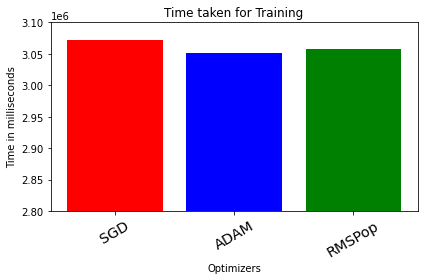

<Figure size 432x288 with 0 Axes>

In [ ]:
#Time for training using SGD = 3071710 ms
#Time for training using Adam = 3051855 ms
#Time for training using RMSProp = 3058404 ms

import matplotlib.pyplot as plt
import numpy as np
label = ['SGD', 'ADAM', 'RMSPop']
Train_time = [3071710,3051855,3058404]
index=np.arange(len(label))
plt.bar(index,Train_time,color=['red','blue','green'])
plt.xlabel('Optimizers')
plt.ylabel('Time in milliseconds')
plt.xticks(index,label,rotation=30,fontsize = 'x-large')
plt.ylim(2800000,3100000)
plt.title('Time taken for Training')
plt.tight_layout()
plt.savefig('Time taken for Training.pdf', format='pdf', dpi=1000)
#plt.style.use("ggplot")
plt.figure()

#PREDICTION

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
#from pyimagesearch import config
from imutils import paths
import numpy as np
import imutils
import random
import cv2
import os
 
# load the trained model from disk
print("[INFO] loading model...")
model = load_model("/content/drive/My Drive/Colab Notebooks/VidData/DATA/activity_detection_DWS.h5")

[INFO] loading model...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Class: Accident
[INFO] Time for Prediction of a Single Frame: 23 ms


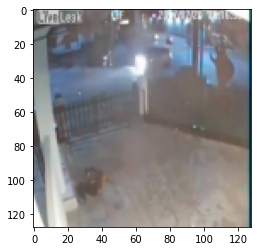

In [ ]:
import matplotlib.pyplot as plt
import datetime

CLASSES = ["Normal", "Fire", "Accident", "Robbery"]
imagePath= "/content/drive/My Drive/Colab Notebooks/explosion/fff/frames/frame17.jpg"

image = cv2.imread(imagePath)
image = image.astype("float32") / 255.0

image = cv2.resize(image,(128, 128),interpolation=cv2.INTER_AREA)

t1= datetime.datetime.now()
preds = model.predict(np.expand_dims(image, axis=0))[0]
t2= datetime.datetime.now()

timeTaken = t2-t1
j = np.argmax(preds)
label = CLASSES[j]
plt.grid(False)
plt.imshow(image)

print("Predicted Class:",label)
print("[INFO] Time for Prediction of a Single Frame:",int(timeTaken.total_seconds()*1000),"ms")

# Training with MobileNet

In [ ]:
import tensorflow as tf
#Initializing the base model
image_size = 128
IMG_SHAPE = (image_size, image_size, 3)
#Downloading data from https://github.com/fchollet/deep-learning-models/releases/download/v0.6/mobilenet_1_0_128_tf_no_top.h5

#Create the base model from the pre-trained model MobileNet V1
base_model_1 = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')
base_model_1.summary()

17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________

In [ ]:
base_model_1.trainable = True
model_MN = tf.keras.Sequential([ base_model_1,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(4, activation='softmax')])
model_MN.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 516       
Total params: 3,360,580
Trainable params: 3,338,692
Non-trainable params: 21,888
_______________________________________

In [ ]:
# initialize the optimizer and model
#opt = SGD(lr = INIT_LR, momentum = 0.9, decay = INIT_LR / NUM_EPOCHS)
#NUM_EPOCHS = 
model_MN.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(), metrics =["accuracy"])
print("[INFO] compiling model...")

#Utilize callback to store the weights of the best model
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_MN11.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=1)

[INFO] compiling model...


In [ ]:
# train the network
print("[INFO] training network...")
HM = model_MN.fit_generator(aug.flow(trainX, trainY, batch_size = BATCH_SIZE),
                        validation_data = (testX, testY),
                        steps_per_epoch = trainX.shape[0] // BATCH_SIZE,
                        epochs = NUM_EPOCHS,
                        class_weight = classWeight,
                        callbacks = [checkpointer],
                        verbose = 1)

[INFO] training network...
Epoch 1/100
2404/112 [===================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 2s 958us/sample - loss: 0.5991 - acc: 0.7525

Epoch 00001: val_acc improved from -inf to 0.75250, saving model to /content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_MN11.hdf5
112/112 [==============================] - 39s 350ms/step - loss: 0.7103 - acc: 0.7486 - val_loss: 0.7370 - va

In [ ]:
plt.style.use("ggplot")
#Plotting Accuracy and Loss during Training
N = np.arange(0, NUM_EPOCHS)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MobileNet V1 Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(N, HM.history['acc'], label='Train Accuracy')
ax1.plot(N, HM.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 101, 5))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(N,HM.history['loss'], label='Train Loss')
ax2.plot(N, HM.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 101, 5))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
#Load our classifier with the weights of the best model
model_MN.load_weights('/content/drive/My Drive/Colab Notebooks/VidData/DATA/best_weights_act_MN11.hdf5')

#Saving the complete model
model_MN.save('/content/drive/My Drive/Colab Notebooks/VidData/DATA/activity_detection_MN11.h5')

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
#model.save(MODEL_PATH)

In [ ]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model_MN.predict(testX, batch_size = BATCH_SIZE)

print(classification_report(testY, 
                            predictions.argmax(axis = 1), 
                            target_names = CLASSES))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
con_mat = confusion_matrix(testY, predictions.argmax(axis = 1))
#print(con_mat)
figure = plt.figure()
sns.heatmap(con_mat, annot=True, cmap=plt.cm.Blues,fmt="d")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.figure()